In [1]:
import sys
import os
import numpy as np
from pathlib import Path

# Add the path to 'lib' directory
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

# Now try importing
from calibration.cv2api.calibrate import read_chessboards,calibrate_camera
from calibration.cv2api.detect import detect_pose
from config.ConfigManager import ConfigManager
from calibration.json_utils.json_functions import generate_json_for_images

config_manager = ConfigManager('config.json')


def calibrate_and_write(project_name,  output_folder):

    image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".jpg") or f.endswith(".png")]
    image_files.sort()  # Ensure files are in order

    allCorners,allIds,imsize,num_of_detected_markers=read_chessboards(image_files)

    print(allCorners)


    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
    print(ret,mtx)
    if(ret!=-1):
        np.save(os.path.join(output_folder,"camera_matrix.npy"), mtx)
        np.save(os.path.join(output_folder,"camera_dist_coeff.npy"),dist)
        config_manager.update_project(project_name, {"calibrated": True, "camera_matrix": mtx.tolist(),
                                                "dist_coeff": dist.tolist()})
        return mtx,dist
    else:
        print("no calibration data were found")
        return None, None 

    



# input_video = "../data/videos/bfrog_4x4.mp4"
# input_folder = None

input = "../node-red/projects/calib_0210//////"

output_folder = f"../node-red/projects/{Path(input).stem}"
project_name = "test"
mtx = None
dist = None
num_of_images = 40

if(os.path.isdir(input)):
    config_manager.update_project(project_name, {"images": output_folder})
    mtx,dist = calibrate_and_write(project_name, output_folder)
else:
    err = os.system(f"sfextract --frame-count {num_of_images} {input} --output {output_folder}")  
    if(err):
        print("Error occured while generating images from video")
    else:
        config_manager.update_project(project_name, {"images": output_folder})
        mtx,dist = calibrate_and_write("test", output_folder)

if mtx is not None and mtx.any():
    generate_json_for_images("../node-red/projects/calib_0210//",os.path.join("../node-red/projects/calib_0210/","transforms_centered.json"),mtx,dist,colmap = True)
else:
    print("Cannot do detection, to little charuco markers were found")


Calibration package is being initialized.
POSE ESTIMATION STARTS:
=> Processing image ../node-red/projects/calib_0210/frame0000.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0001.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0002.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0003.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0004.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0005.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0006.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0007.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0008.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0009.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0010.png
(2128, 4200)
=> Processing image ../node-red/projects/calib_0210/frame0011.png

TypeError: Object of type ndarray is not JSON serializable

In [5]:
False >0

False

In [54]:
import cv2
from matplotlib import pyplot as plt
ARUCO_DICT = cv2.aruco.DICT_4X4_50
SQUARES_VERTICALLY = 7
SQUARES_HORIZONTALLY = 5
SQUARE_LENGTH = 0.056
MARKER_LENGTH = 0.042
def detect_pose(image, camera_matrix, dist_coeffs, debug_viz=False):
    # Use the original image for detection
    image_for_detection = image.copy()

    # Define the aruco dictionary and charuco board
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard(
        (SQUARES_VERTICALLY, SQUARES_HORIZONTALLY),
        SQUARE_LENGTH,
        MARKER_LENGTH,
        dictionary
    )

    # Customize detector parameters
    params = cv2.aruco.DetectorParameters()
    params.adaptiveThreshConstant = 7  # Try increasing or decreasing to control thresholding
    params.adaptiveThreshWinSizeMin = 3  # Lowering window size can help with small markers
    params.adaptiveThreshWinSizeMax = 23  # Increase for more aggressive thresholding
    params.adaptiveThreshWinSizeStep = 10  # Size step in between windows
    
    params.minMarkerPerimeterRate = 0.03  # Smaller markers, so reduce the minimum perimeter
    params.maxMarkerPerimeterRate = 4.5   # Allow for larger perimeter in detection
    params.polygonalApproxAccuracyRate = 0.03  # Tighter approximation for more accurate corner detection
    params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX  # Use sub-pixel refinement for corners
    params.cornerRefinementMaxIterations = 50  # More iterations for better refinement
    params.cornerRefinementWinSize = 5  # Control the window size for corner refinement
    params.cornerRefinementMinAccuracy = 0.02  # Increase accuracy requirement for corner refinement

    # Detect markers in the original image
    marker_corners, marker_ids, _ = cv2.aruco.detectMarkers(
        image_for_detection, dictionary, parameters=params
    )
    print(f"Number of markers detected: {len(marker_corners)}")

    # Proceed if markers are detected
    if marker_ids is not None:
        # Interpolate CharUco corners
        charuco_retval, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(
            marker_corners, marker_ids, image_for_detection, board
        )

        # Proceed if enough corners are found
        if charuco_retval and charuco_retval >= 4:
            # Estimate the pose
            retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(
                charuco_corners, charuco_ids, board, camera_matrix, dist_coeffs, None, None
            )

            if debug_viz:
                cv2.aruco.drawDetectedMarkers(image_for_detection, marker_corners, marker_ids)
                cv2.aruco.drawDetectedCornersCharuco(image_for_detection, charuco_corners, charuco_ids)
                if retval:
                    cv2.drawFrameAxes(image_for_detection, camera_matrix, dist_coeffs, rvec, tvec, length=0.1)
                plt.imshow(cv2.cvtColor(image_for_detection, cv2.COLOR_BGR2RGB))
                plt.show()

            # Proceed if pose estimation is successful
            if retval:
                return True, rvec, tvec
            else:
                print("Not enough corners for pose estimation.")
                return False, None, None
        else:
            print("Not enough corners for pose estimation.")
            return False, None, None
    else:
        print("Not enough markers detected.")
        return False, None, None


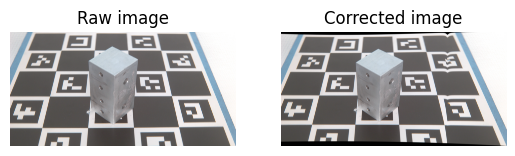

Number of markers detected: 7


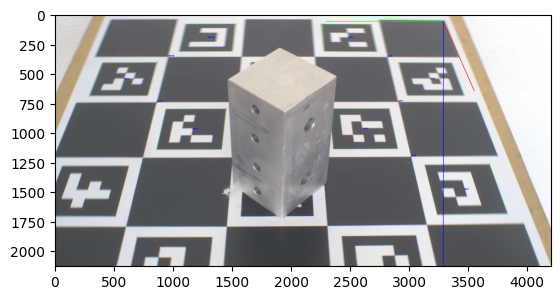

(True, array([[-1.09320145],
       [ 1.31502621],
       [ 1.35419657]]), array([[ 0.22591693],
       [-0.00794065],
       [ 0.53701411]]))


In [56]:
from matplotlib import pyplot as plt
import cv2


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

i=5 # select image id
plt.figure()
frame = cv2.imread("../node-red/projects/bench_0210__all//"+"/bench_0210__frame0132.png")
img_undist = undistort_image(frame,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()
print(detect_pose(frame,mtx,dist,debug_viz = True))


2
Not enough markers detected.
(False, None, None)


In [2]:
from lib.calibration.viz_utils.viz_cameras import camera_with_frustums 

In [4]:
camera_with_frustums("../node-red/projects/benchmark_4x4_phone/transforms_centered.json","../node-red/projects/benchmark_4x4_phone/cameras.html")